In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('colorblind')
sns.set_context('notebook')
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('axes',labelsize=20) 
matplotlib.rc('text', usetex = True)

/home/oliver/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


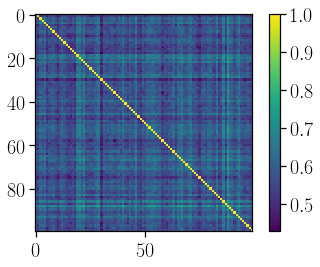

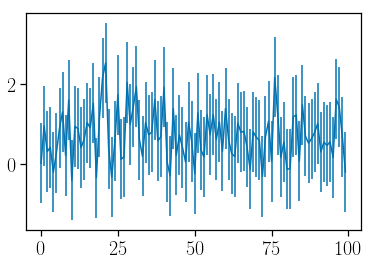

In [2]:
npts = 100

np.random.seed(24601)
A = np.random.rand(npts, npts)
Sigma = np.dot(A, A.T)
Sigma /= Sigma.max()
err = np.ones(npts)
np.fill_diagonal(Sigma, err**2)

plt.imshow(Sigma)
plt.colorbar()
plt.show()

means = np.zeros(npts)+0.
y = np.random.multivariate_normal(means, Sigma)
plt.errorbar(range(npts), y, yerr=err)
plt.show()

### Model without covariance

In [3]:
import pystan
overwrite=False
nocov = '''
data {
    int<lower = 0> N;
    vector[N] y;
    vector[N] err;
}
parameters {
    vector[N] ytrue;                         //Can't have something being closer than 1 parsec!
}
model {
    y ~ normal(ytrue, err);
}
'''
import os
import pickle
model_path = 'nocov.pkl'
if overwrite:
    sm = pystan.StanModel(model_code = nocov)
    with open(model_path, 'wb') as f:
        pickle.dump(sm, f)
else:
    if os.path.isfile(model_path):
        print('Loading in existing Stan Model') 
        sm = pickle.load(open(model_path, 'rb'))
    else:
        print('Saving Stan Model') 
        sm = pystan.StanModel(model_code = nocov)
        with open(model_path, 'wb') as f:
            pickle.dump(sm, f)

Loading in existing Stan Model


In [4]:
dat = {'N':len(y),
      'y' : y,
      'err' : err}
fit = sm.sampling(data=dat, iter=10000, chains=2)

0.7097971150239364


INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


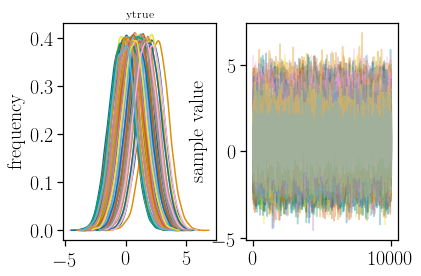

In [5]:
print(np.median(fit['ytrue']))
fit.plot()
plt.show()

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


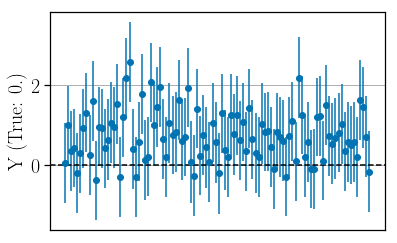

In [6]:
plt.errorbar(range(npts), np.median(fit['ytrue'],axis=0),
            yerr = np.std(fit['ytrue'],axis=0),fmt='o')
plt.axhline(np.mean(means), c='k', linestyle='--')
plt.ylabel('Y (True: 0.)')
plt.xticks([])
plt.grid()
plt.show()

### With covariance matrix

In [7]:
import pystan
overwrite=False
cov_simple = '''
data {
    int<lower = 0> N;
    vector[N] y;
    cov_matrix[N] Sigma;
}
parameters {
    vector[N] ytrue;                         //Can't have something being closer than 1 parsec!
}
model {
    y ~ multi_normal(ytrue, Sigma);
}
'''
import os
import pickle
model_path = 'cov_simple.pkl'
if overwrite:
    sm = pystan.StanModel(model_code = cov_simple)
    with open(model_path, 'wb') as f:
        pickle.dump(sm, f)
else:
    if os.path.isfile(model_path):
        print('Loading in existing Stan Model') 
        sm = pickle.load(open(model_path, 'rb'))
    else:
        print('Saving Stan Model') 
        sm = pystan.StanModel(model_code = cov_simple)
        with open(model_path, 'wb') as f:
            pickle.dump(sm, f)

Loading in existing Stan Model


In [8]:
dat = {'N':len(y),
      'y' : y,
      'Sigma' : Sigma}
fit = sm.sampling(data=dat, iter=10000, chains=2)

0.7218831214616905


INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


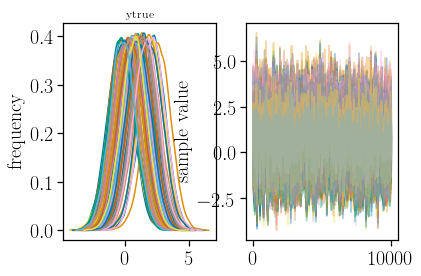

In [9]:
print(np.median(fit['ytrue']))
fit.plot()
plt.show()

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


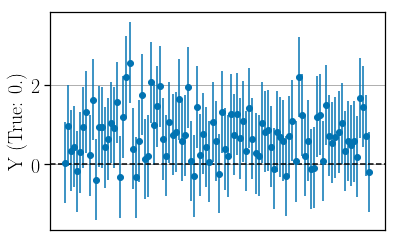

In [10]:
plt.errorbar(range(npts), np.median(fit['ytrue'],axis=0),
            yerr = np.std(fit['ytrue'],axis=0),fmt='o')
plt.axhline(np.mean(means), c='k', linestyle='--')
plt.ylabel('Y (True: 0.)')
plt.xticks([])
plt.grid()
plt.show()

### With faster covariance matrix

In [11]:
import pystan
overwrite=False
cov_fast = '''
functions {
    real precalc_multinormal_lpdf(vector y, vector y_true, real logdetc, matrix invc, int N, real Nfloat){
        vector[N] r;       
        r = y - y_true;

        return -0.5 * ((r' * invc * r) + logdetc + Nfloat * log(2*pi()));
    }
}
data {
    int<lower = 0> N;
    real Nfloat;
    vector[N] y;
    matrix[N, N] invc;
    real logdetc;
}
parameters {
    vector[N] ytrue;                         //Can't have something being closer than 1 parsec!
}
model {
    y ~ precalc_multinormal(ytrue, logdetc, invc, N, Nfloat);
}
'''
import os
import pickle
model_path = 'cov_fast.pkl'
if overwrite:
    sm = pystan.StanModel(model_code = cov_fast)
    with open(model_path, 'wb') as f:
        pickle.dump(sm, f)
else:
    if os.path.isfile(model_path):
        print('Loading in existing Stan Model') 
        sm = pickle.load(open(model_path, 'rb'))
    else:
        print('Saving Stan Model') 
        sm = pystan.StanModel(model_code = cov_fast)
        with open(model_path, 'wb') as f:
            pickle.dump(sm, f)

Loading in existing Stan Model


In [12]:
dat = {'N':len(y),
       'Nfloat':np.float(len(y)),
      'y' : y,
      'invc': np.linalg.inv(Sigma),
      'logdetc':np.linalg.det(Sigma)}
fit = sm.sampling(data=dat, iter=10000, chains=2)

0.7037194505992391


INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


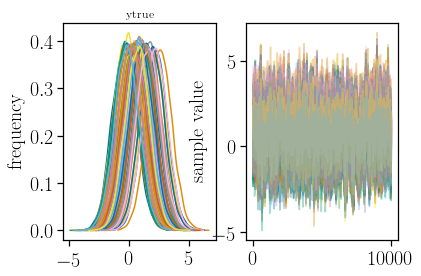

In [13]:
print(np.median(fit['ytrue']))
fit.plot()
plt.show()

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


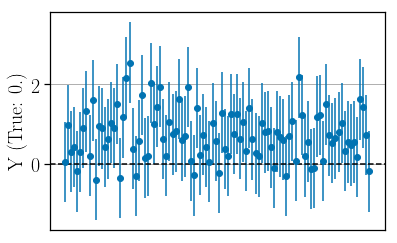

In [14]:
plt.errorbar(range(npts), np.median(fit['ytrue'],axis=0),
            yerr = np.std(fit['ytrue'],axis=0),fmt='o')
plt.axhline(np.mean(means), c='k', linestyle='--')
plt.ylabel('Y (True: 0.)')
plt.xticks([])
plt.grid()
plt.show()